In [105]:
import boto3
from datetime import datetime
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

In [20]:
class Job:
    def __init__(self, s3_client, name, timestamp):
        self.bucket = 'dejan'
        self.node_name = 'dejan-mig-ml-11-a100-hv-otdhqujzb2nx-node-'
        
        self.name = name
        self.timestamp = timestamp
        self.n_nodes = int(name.split('-')[0][1]) if name.startswith('n') else 8
        self.files = []
        self.topology = self.get_topology(s3_client)
        self.epoch_times = self.get_epoch_times(s3_client)
        
    def get_topology(self, s3_client):
        topology = [] # list of number of used gpu per node
        
        for i in range(9):
            filename = self.name + '-' + self.node_name + str(i)
            try:
                s3_client.download_file(self.bucket, filename, filename)
            except:
                continue
            active_gpus = set()
            with open(filename, 'r') as f:
                for line in f.readlines():
                    if line.startswith('active_gpus'):
                        line_split = line.split(':')
                        if len(line_split) == 1:
                            continue
                        for gpu in line_split[1].split():
                            if gpu in ['0','1','2','3']:
                                active_gpus.add(gpu)
                                
            topology.append(len(active_gpus))
            os.remove(filename)
            
        return sorted(topology)
    
    def add_file(self, filename):
        self.files.append(filename)
        
    def get_epoch_times(self, s3_client):
        s3_client.download_file(self.bucket, self.name, self.name)
        with open(self.name, 'r') as f:
            for line in f.readlines():
                if line.startswith('epoch_times'):
                    epoch_times = [round(float(x)) for x in line.split(':')[1].split()]
        os.remove(self.name)
        return epoch_times
    
    def get_average_epoch_time(self):
        return sum(self.epoch_times) // len(self.epoch_times)
        
    def __str__(self):
        return 'job name: ' + \
               self.name + \
               '\ntimestamp: ' + \
               str(self.timestamp) + \
               '\nnumber of nodes: ' + \
               str(self.n_nodes) + \
               '\ntopology: ' + \
               ' '.join([str(x) for x in self.topology]) + \
               '\nnumber of active GPUs: ' + \
               str(sum(self.topology)) + \
               '\nepoch times: ' + \
               ' '.join([str(x) for x in self.epoch_times]) + \
               '\naverage epoch time: ' + \
               str(sum(self.epoch_times) // len(self.epoch_times)) + \
               '\n'

In [21]:
cutoff_datetime = datetime(2022, 11, 16, 22, 0, 0, 0).replace(tzinfo=None)
s3 = boto3.resource('s3', endpoint_url='https://s3.cern.ch')
my_bucket = s3.Bucket('dejan')
files = my_bucket.objects.filter()
files = [[obj.key, obj.last_modified] \
         for obj in sorted(files, key=lambda x: x.last_modified, reverse=True) \
         if 'desy-3dgan' in obj.key and \
         cutoff_datetime < obj.last_modified.replace(tzinfo=None)]

In [22]:
s3_client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
jobs = {}
job_name = None

for i in range(len(files)):
    if not job_name and 'node' in files[i][0]:
        continue
        
    if not 'node' in files[i][0]:
        job_name = files[i][0]
        jobs[job_name] = Job(s3_client, job_name, files[i][1])
        
    jobs[job_name].add_file(files[i][0])

<Figure size 1440x480 with 0 Axes>

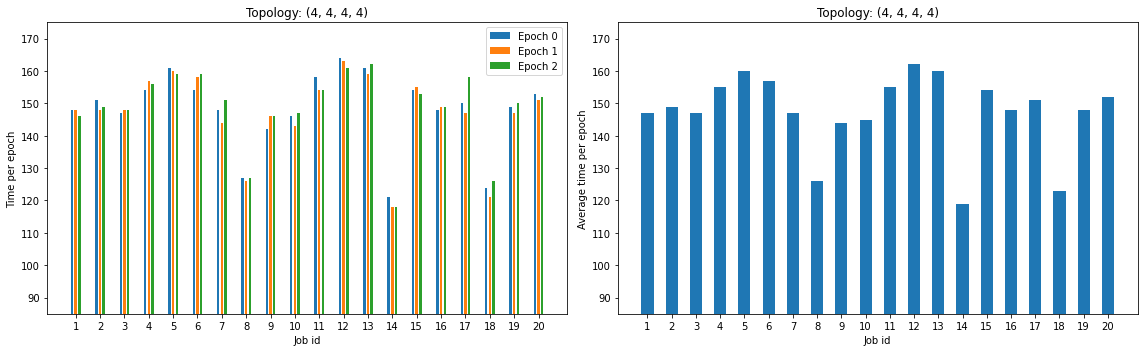

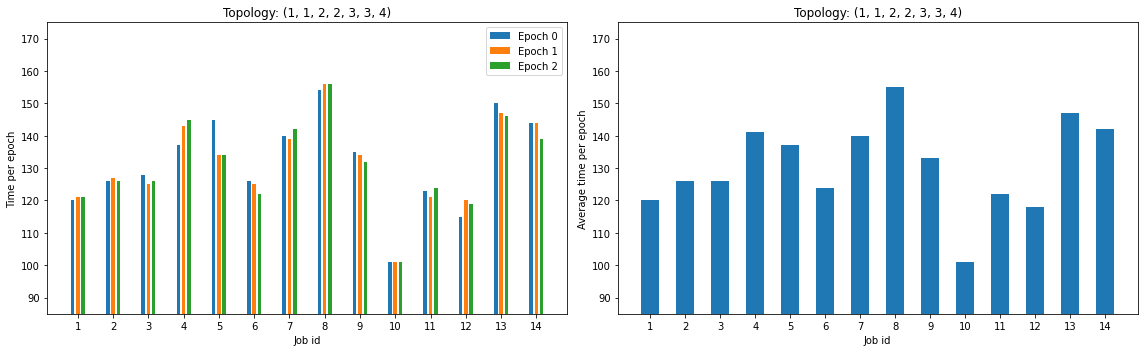

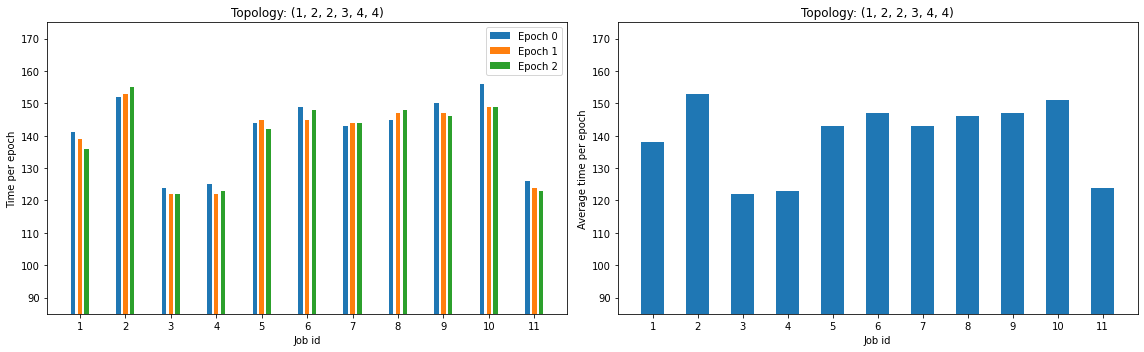

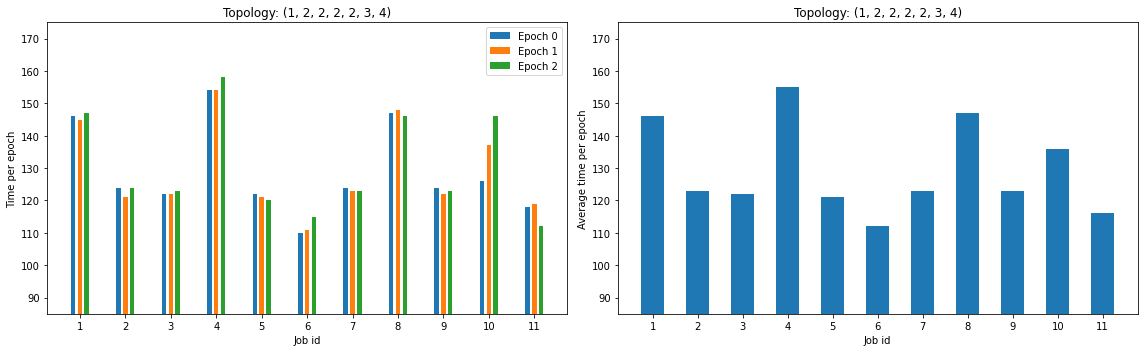

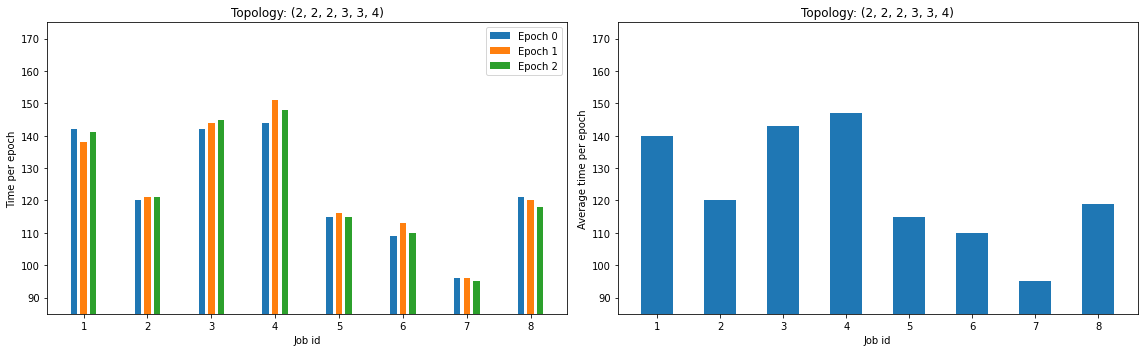

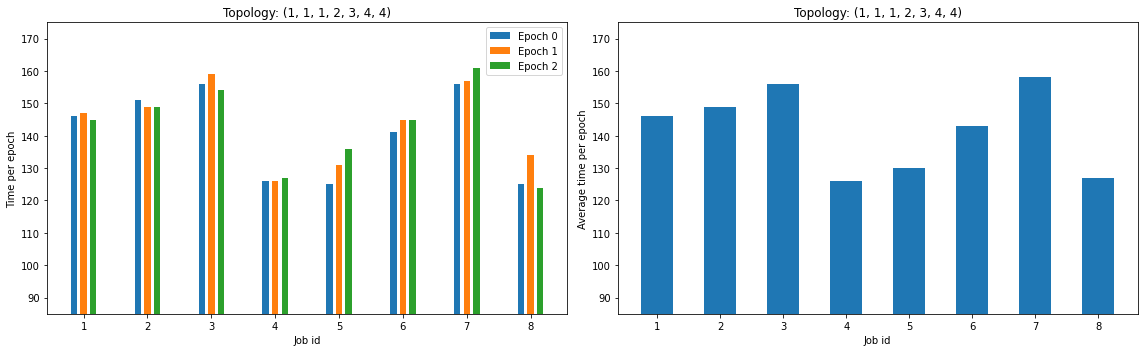

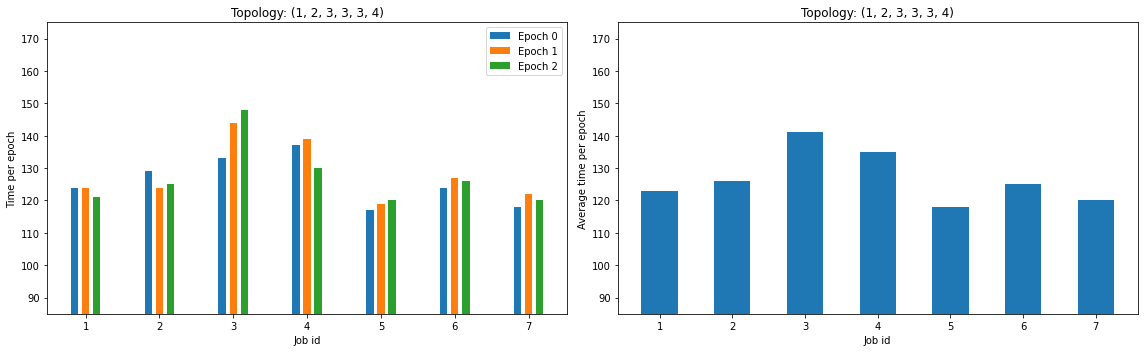

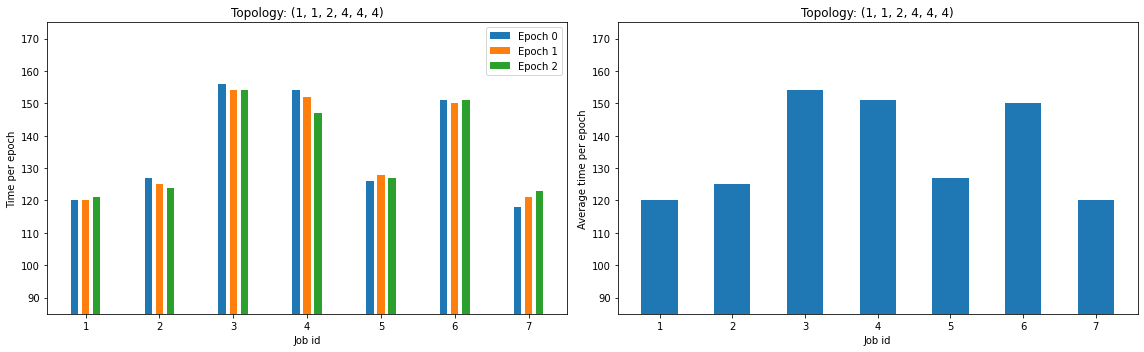

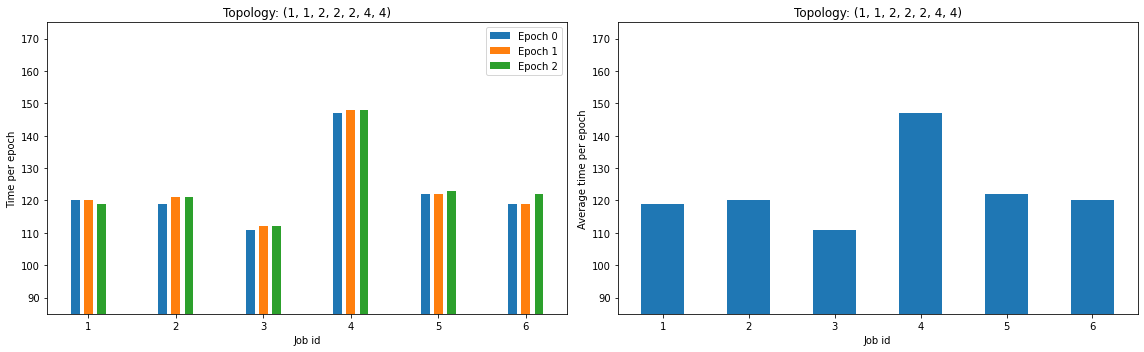

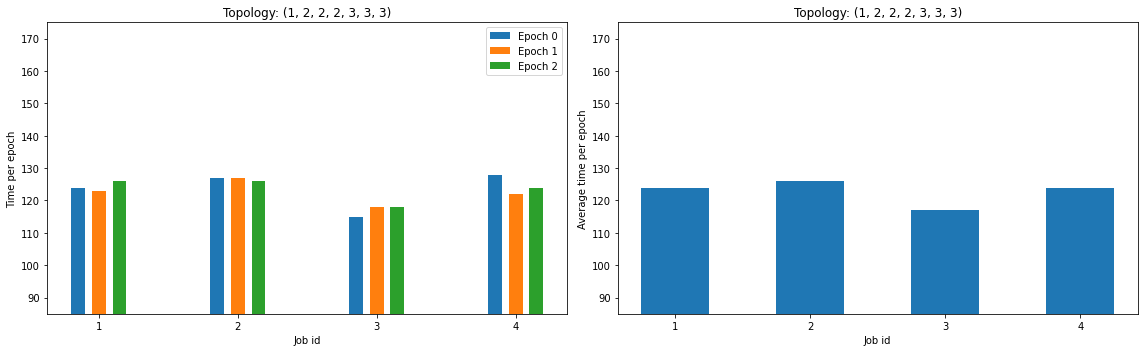

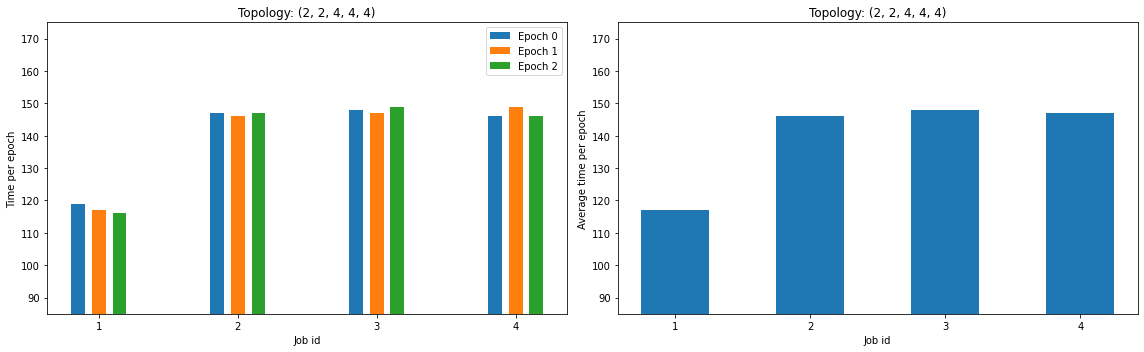

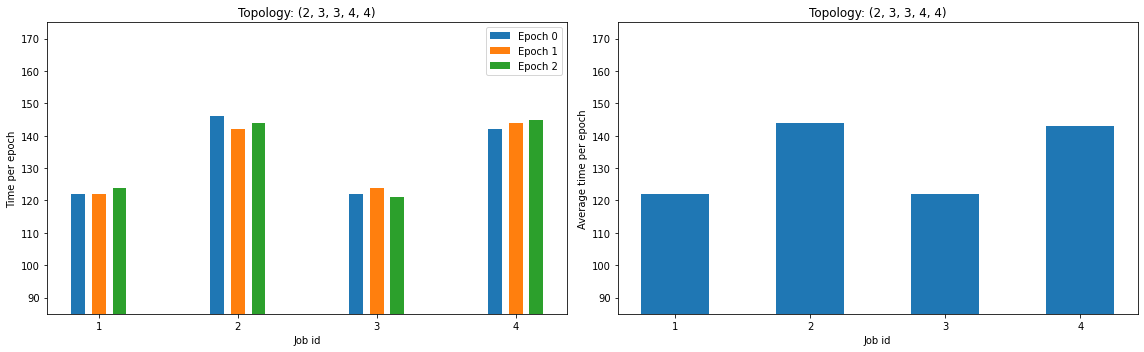

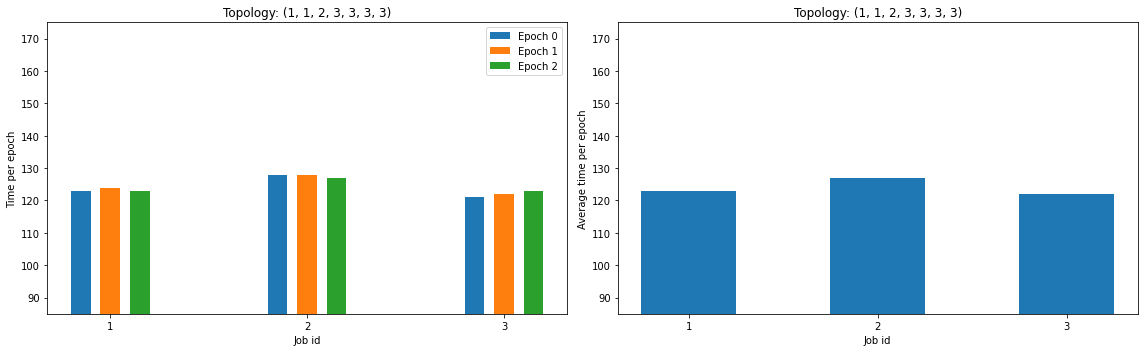

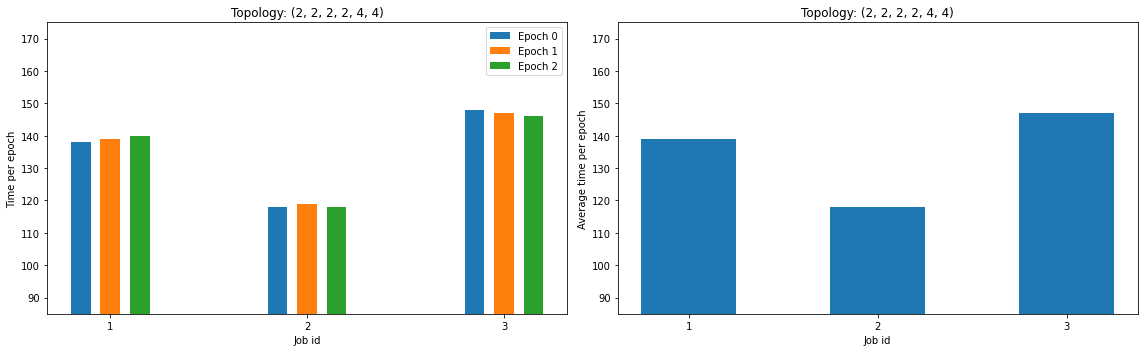

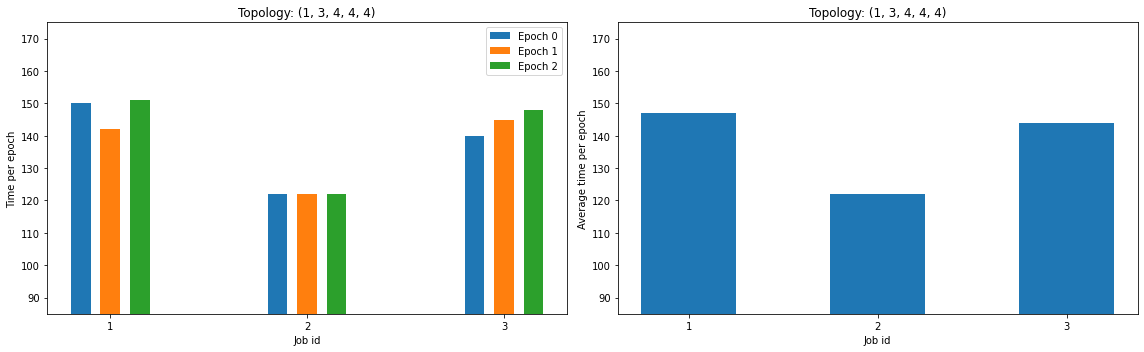

In [120]:
figure(figsize=(18, 6), dpi=80)
jobs_top = {}
for job_name, job in jobs.items():
    topology = [x for x in job.topology if x != 0]
        
    toplogy_tuple = tuple(topology)
    if not toplogy_tuple in jobs_top:
        jobs_top[toplogy_tuple] = []
        
    jobs_top[toplogy_tuple].append(job)
    
for top, jobs_parsed in sorted([[k, v] for k, v in jobs_top.items()], key=lambda x: len(x[1]), reverse=True):
    if len(jobs_parsed) <= 2:
        continue
        
    average_times = [job.get_average_epoch_time() for job in jobs_parsed]
    
    epoch_0 = [job.epoch_times[0] for job in jobs_parsed]
    epoch_1 = [job.epoch_times[1] for job in jobs_parsed]
    epoch_2 = [job.epoch_times[2] for job in jobs_parsed]
    
    #if max(average_times) / min(average_times) > 1.1:
    #    continue
        
    #print(top, ':', [str(tm) for tm in average_times])
    x = np.arange(1, len(average_times) + 1)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    fig.set_size_inches(16, 5)
    #plt.plot(average_times)
    #axes[0] = plt.gca()
    axes[0].set_ylim([85, 175])
    axes[0].set_ylabel('Time per epoch')    
    axes[0].bar(x - 0.15, epoch_0, width=0.1)
    axes[0].bar(x, epoch_1, width=0.1)
    axes[0].bar(x + 0.15, epoch_2, width=0.1)
    axes[0].legend(['Epoch 0', 'Epoch 1', 'Epoch 2'])
    axes[0].set_xlabel('Job id')
    axes[0].set_title('Topology: ' + str(top))
    axes[0].set_xticks(x, x)
    
    axes[1].set_ylim([85, 175])
    axes[1].set_ylabel('Average time per epoch')   
    axes[1].bar(x, average_times, width=0.5)
    axes[1].set_xlabel('Job id')
    axes[1].set_title('Topology: ' + str(top))
    axes[1].set_xticks(x, x)
    fig.tight_layout()
    plt.savefig('/eos/user/d/dgolubov/a100-results/top-' + '-'.join([str(x) for x in top]) + '.png')
    plt.show()

In [ ]:
print(len(jobs))
with open('a100_topology_experiment.txt', 'w') as f:
    for k, v in jobs.items():
        print(v)
        f.write(str(v))
        f.write('\n')

120
job name: n8-desy-3dgan-16-workers-ev9frt8kda
timestamp: 2022-11-18 04:05:43.067000+00:00
number of nodes: 8
topology: 0 1 1 2 3 3 3 3
number of active GPUs: 16
epoch times: 123 124 123
average epoch time: 123

job name: n8-desy-3dgan-16-workers-ejsm2sgpwh
timestamp: 2022-11-18 03:56:51.280000+00:00
number of nodes: 8
topology: 0 0 2 2 2 3 3 4
number of active GPUs: 16
epoch times: 142 138 141
average epoch time: 140

job name: n8-desy-3dgan-16-workers-tfxpy371dv
timestamp: 2022-11-18 03:47:14.629000+00:00
number of nodes: 8
topology: 0 1 1 2 2 2 4 4
number of active GPUs: 16
epoch times: 120 120 119
average epoch time: 119

job name: n8-desy-3dgan-16-workers-xrx4riak3q
timestamp: 2022-11-18 03:38:33.096000+00:00
number of nodes: 8
topology: 0 1 2 2 2 3 3 3
number of active GPUs: 16
epoch times: 124 123 126
average epoch time: 124

job name: n8-desy-3dgan-16-workers-li2owpa8qg
timestamp: 2022-11-18 03:29:37.613000+00:00
number of nodes: 8
topology: 0 1 1 2 3 3 3 3
number of active 